In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.optim as optim

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

from torchinfo import summary

import time
import random 


import data_utils.pulse as pulse
import models.tools as models_tools
import models.vae as models_vae
import models.fcnn as models_fcnn
import models.rf as models_rf

import data_utils.data_analysis as data_analysis

In [2]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

## Loading the dataset

In [3]:
filename='datasets/galadriel_dataset_25_03_13_high_res.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
       shot number   order2   order3     order4  goodness
0           200378  34400.0 -23000.0 -5500000.0  0.878217
1           200379  34400.0 -23000.0 -5500000.0  1.025813
2           200380  34400.0 -23000.0 -5500000.0  0.853794
3           200381  34400.0 -23000.0 -5200000.0  1.003888
4           200382  34400.0 -23000.0 -5200000.0  1.022131
...            ...      ...      ...        ...       ...
15428       215808  35400.0  28000.0 -4000000.0  1.267706
15429       215809  35400.0  28000.0 -4000000.0  1.275014
15430       215810  35400.0  28000.0 -3700000.0  1.076831
15431       215811  35400.0  28000.0 -3700000.0  1.062826
15432       215812  35400.0  28000.0 -3700000.0  1.065211

[15433 rows x 5 columns]
----
Time values
0    -115.458450
1    -104.962227
2     -94.466005
3     -83.969782
4     -73.473559
5     -62.977336
6     -52.481114
7     -41.984891
8     -31.488668
9     -20.992445
10    -10.496223
11      0.000000
12     10.496223
13     20.992445
14     31.4886

In [4]:
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

### Pulse reconstruction

In [5]:
#time in fs (it is the boundary)
#using DASK to accelerate computing
def pulse_reconst_dask(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = delayed(pulse.pulse)(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        #p_list.append(p.intensity)
        p_list.append(p)
    p_list=compute(p_list)[0]
    p_int=[p.intensity for p in p_list]
    return t,pd.DataFrame(p_int)
    #return t,p_int

In [6]:
#time in fs (it is the boundary)
def pulse_reconst_old(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [7]:
filename_pulse='datasets/pulse_250313.h5'

In [8]:
#read the data
#df_time_50=pd.read_hdf(filename_pulse,'df_time_50',mode='r')
#df_pulse_50=pd.read_hdf(filename_pulse,'df_pulse_50')
#t_50=df_time_50.to_numpy()

df_time_200=pd.read_hdf(filename_pulse,'df_time_200')
df_pulse_200=pd.read_hdf(filename_pulse,'df_pulse_200')
t_200=df_time_200.to_numpy()

### Drop shots whith bad goodness

In [9]:
goodness_val=1.2
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values
#print(good_shots_list)
df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [10]:
df_input_reduced

,shot number,order2,order3,order4,goodness
0,200396,34400.0,-23000.0,-3700000.0,1.224409
1,200397,34400.0,-23000.0,-3700000.0,1.309285
2,200417,34400.0,-21500.0,-3700000.0,1.258745
3,200418,34400.0,-21500.0,-3700000.0,1.246534
4,200419,34400.0,-21500.0,-3700000.0,1.259270
...,...,...,...,...,...
3990,215804,35400.0,28000.0,-4300000.0,1.224609
3991,215806,35400.0,28000.0,-4300000.0,1.231252
3992,215807,35400.0,28000.0,-4000000.0,1.276099
3993,215808,35400.0,28000.0,-4000000.0,1.267706


In [11]:
#split the dataset (X:dazzler param, Y:wizzler) 
#X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_pulse_200,rand_split=False)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input_reduced,df_pulse_200_reduced,rand_split=False)

In [12]:
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


## Forward model

In [13]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=models_rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    #y_predict_forward=models_rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf#,df_error_forward_rf

In [14]:
%%time
forward_model_rf=train_rf_forward(X_train, X_test, y_train, y_test)

CPU times: user 8.76 s, sys: 505 ms, total: 9.27 s
Wall time: 9.48 s


# Roundtrip models

**Random Forest**

In [15]:
%%time
roundmodel_rf=models_rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)
mae_error_round=roundmodel_rf.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 3min 41s, sys: 557 ms, total: 3min 41s
Wall time: 3min 41s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


**MLP**

In [16]:
#round model NN
roundmodel_mlp=models_fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodel_mlp.train(100,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   400,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodel_mlp.predict(y_test)
error_round_model_mlp=roundmodel_mlp.error_calc_mae()

Training the forward model
Finished epoch 0,latest loss 0.03380713611841202
Finished epoch 20,latest loss 0.00021581543842330575
Finished epoch 40,latest loss 0.00013160832168068737
Finished epoch 60,latest loss 0.00010718153498601168
Finished epoch 80,latest loss 9.988837700802833e-05
Finished epoch 99,latest loss 9.29841335164383e-05
Total time taken to train the model: 35.37s
Training the backward model
Finished epoch 0,latest loss 1.017814040184021
Finished epoch 50,latest loss 0.05487308278679848
Finished epoch 100,latest loss 0.023069823160767555
Finished epoch 150,latest loss 0.014205214567482471
Finished epoch 200,latest loss 0.009337177500128746
Finished epoch 250,latest loss 0.006748106796294451
Finished epoch 300,latest loss 0.005266909021884203
Finished epoch 350,latest loss 0.0044008102267980576
Finished epoch 399,latest loss 0.004497014917433262
Total time taken to train the model: 59.55s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

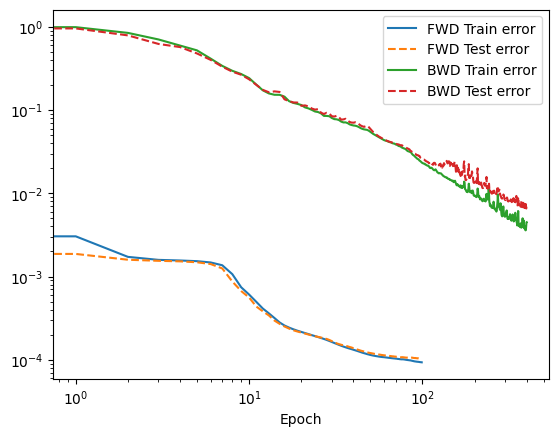

In [17]:
plt.plot(roundmodel_mlp.train_error_fwd,label='FWD Train error')
plt.plot(roundmodel_mlp.test_error_fwd,linestyle='--',label='FWD Test error')
plt.plot(roundmodel_mlp.train_error_bwd,label='BWD Train error')
plt.plot(roundmodel_mlp.test_error_bwd,linestyle='--',label='BWD Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Random guess models (+RF FWD)

In [18]:
## Random guess 'model'
o2min=X_test['order2'].min()
o2max=X_test['order2'].max()
o3min=X_test['order3'].min()
o3max=X_test['order3'].max()
o4min=X_test['order4'].min()
o4max=X_test['order4'].max()

o2_list=[]
o3_list=[]
o4_list=[]
for i in range(len(X_test)):
    o2_list.append(random.uniform(o2min,o2max))
    o3_list.append(random.uniform(o3min,o3max))
    o4_list.append(random.uniform(o4min,o4max))

X_test_rand=pd.DataFrame({'order2':o2_list,'order3':o3_list,'order4':o4_list})#,o3_list,o4_list])#,columns=['order2','order3','order4'])

#Pass those predicted (but random) beta values to the forward model
y_pred_fwd_rand=models_rf.make_rf_prediction(forward_model_rf,X_test_rand)
#calculate the error (Mean Absolute Error)
error_rand=abs(y_test-y_pred_fwd_rand)
error_rand=error_rand.sum(axis=1)/y_test.shape[1]

### CVAE

In [19]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
cvae=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)

batch_size = 10#just as an example
y_length=len(t_200)
x_length=len(X_train.columns)
summary(cvae,[(batch_size,x_length),(batch_size,y_length)])

Layer (type:depth-idx)                   Output Shape              Param #
ConditionalVAE                           [10, 3]                   --
├─Sequential: 1-1                        [10, 51]                  --
│    └─Sequential: 2-1                   [10, 244]                 --
│    │    └─Linear: 3-1                  [10, 244]                 50,020
│    │    └─LeakyReLU: 3-2               [10, 244]                 --
│    └─Sequential: 2-2                   [10, 204]                 --
│    │    └─Linear: 3-3                  [10, 204]                 49,980
│    │    └─LeakyReLU: 3-4               [10, 204]                 --
│    └─Sequential: 2-3                   [10, 102]                 --
│    │    └─Linear: 3-5                  [10, 102]                 20,910
│    │    └─LeakyReLU: 3-6               [10, 102]                 --
│    └─Sequential: 2-4                   [10, 51]                  --
│    │    └─Linear: 3-7                  [10, 51]                  5,253


In [20]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			cvae,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cpu
Finished epoch 0,latest loss 0.4988751709461212
Finished epoch 20,latest loss 0.03971554711461067
Finished epoch 40,latest loss 0.0277225561439991
Finished epoch 60,latest loss 0.02135259285569191
Finished epoch 80,latest loss 0.00774796586483717
Finished epoch 100,latest loss 0.006458019372075796
Finished epoch 120,latest loss 0.0042986199259757996
Finished epoch 140,latest loss 0.003687337739393115
Finished epoch 160,latest loss 0.003257808042690158
Finished epoch 180,latest loss 0.005025319755077362
Finished epoch 200,latest loss 0.0024839432444423437
Finished epoch 220,latest loss 0.004632049240171909
Finished epoch 240,latest loss 0.0028803907334804535
Finished epoch 260,latest loss 0.0030285425018519163
Finished epoch 280,latest loss 0.0026894290931522846
Finished epoch 299,latest loss 0.0023561634588986635
Total time taken to train the model: 157.14s


Text(0.5, 0, 'Epoch')

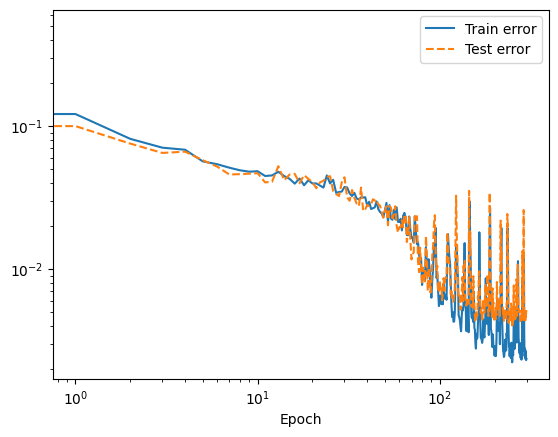

In [21]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### Predictions

In [22]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,y_test,device):
    #index_shot=150
    y_ex=y_test.iloc[index_shot]
    X_ex=X_test.iloc[index_shot]
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    print(len(y_ex))
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex)))
    print('Known Dazzler values',X_ex)

    shot_numb=get_shot_num(index_shot,y_test,df_input)


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    
    y_order2=np.linspace(0,1,10)
    x_order2=np.full_like(y_order2,X_ex['order2'])

    y_order3=np.linspace(0,1,10)
    x_order3=np.full_like(y_order3,X_ex['order3'])

    y_order4=np.linspace(0,1,10)
    x_order4=np.full_like(y_order4,X_ex['order4'])


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Real shot (#'+str(shot_numb)+')',linestyle='--',linewidth=3)
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3)
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3)
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3)
    plt.ylabel('Intensity',size=15)
    plt.xlabel('t(fs)',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=4)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3)
    plt.plot(x_order2,y_order2,linestyle=':',label='Real value',linewidth=3)
    plt.plot(x_o2_rf,y_o2_rf,linestyle='--',label='RF prediction',linewidth=3)
    plt.plot(x_o2_nn,y_o2_nn,linestyle='--',label='MLP prediction',linewidth=3)
    plt.xlabel(r'$\beta_2$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 1)
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_3|P^*)$',linewidth=4)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.5,linewidth=3)
    plt.plot(x_order3,y_order3,linestyle=':',label='Real value',linewidth=3)
    plt.plot(x_o3_rf,y_o3_rf,linestyle='--',label='RF prediction',linewidth=3)
    plt.plot(x_o3_nn,y_o3_nn,linestyle='--',label='MLP prediction',linewidth=3)
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 1)
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred $P(\beta_4|P^*)$',linewidth=4)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3)
    plt.plot(x_order4,y_order4,linestyle=':',label='Real value',linewidth=3)
    plt.plot(x_o4_rf,y_o4_rf,linestyle='--',label='RF prediction',linewidth=3)
    plt.plot(x_o4_nn,y_o4_nn,linestyle='--',label='MLP prediction',linewidth=3)
    plt.xlabel(r'$\beta_4$',size=15)
    plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

201
Known Dazzler values order2      34600.0
order3      28000.0
order4   -3700000.0
Name: 805, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


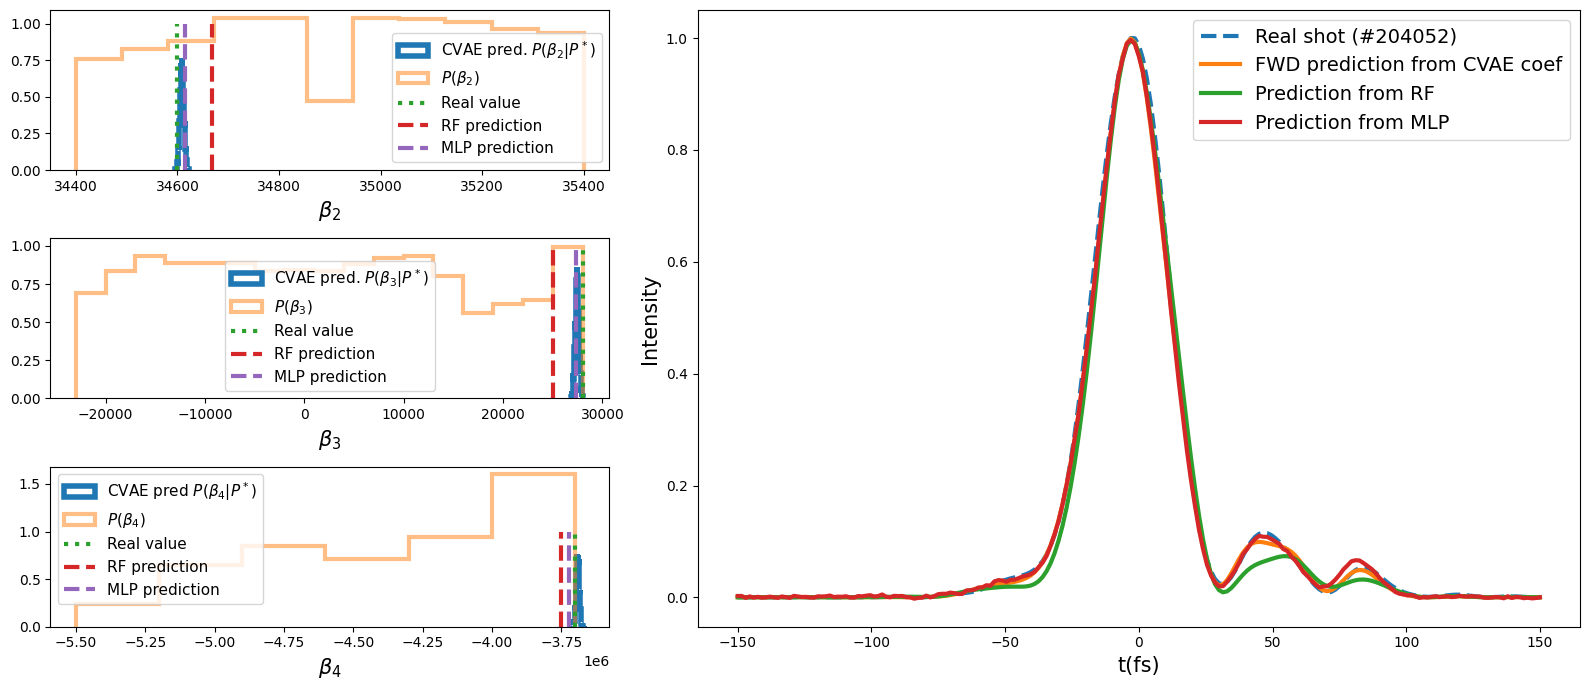

In [23]:
index_shot=106
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

201
Known Dazzler values order2      35050.0
order3       7000.0
order4   -4900000.0
Name: 2543, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


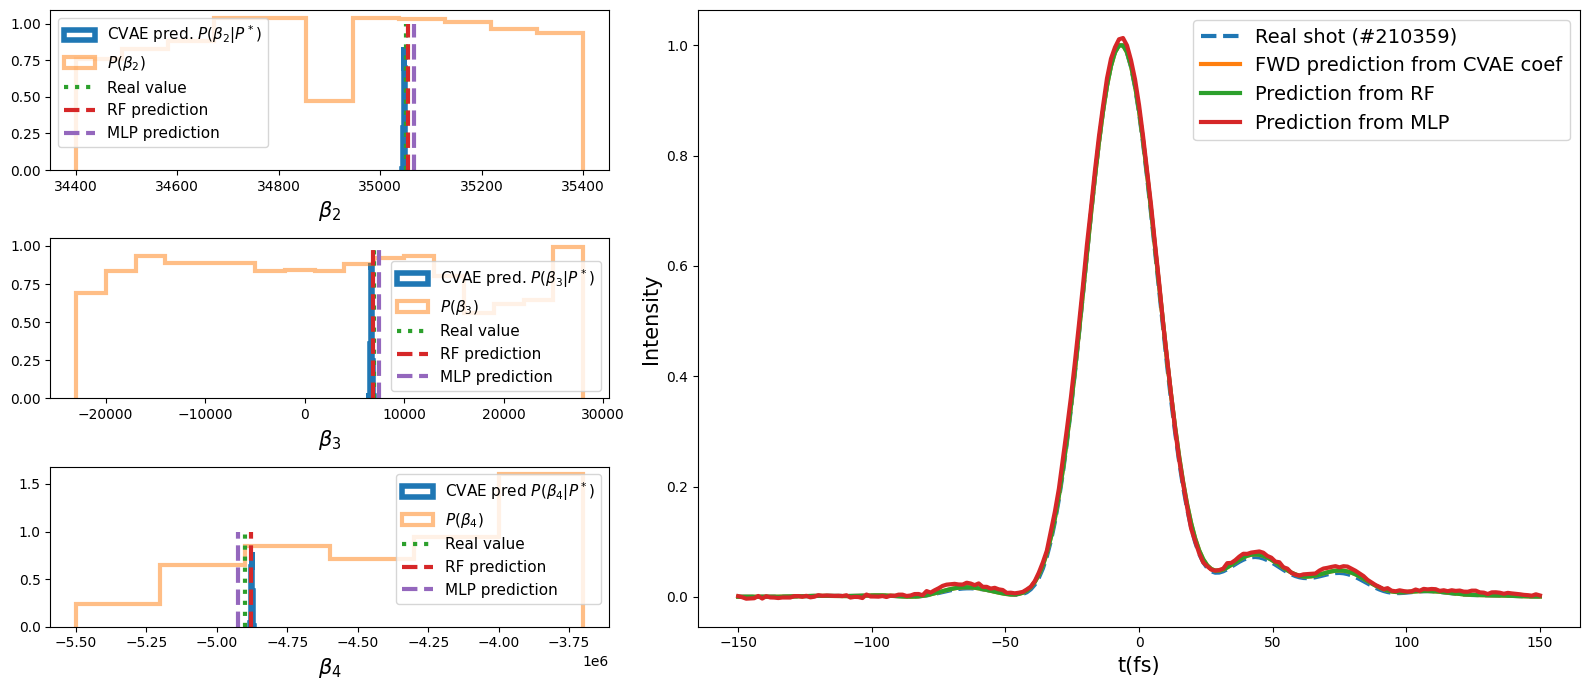

In [24]:
index_shot=125
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

### Calculate error in CVAE model

In [25]:
# The function gets the Y from a given shot. Predicts its X values. Then uses those X to reconstruct a pulse Y
#        using the forward model. Finally calculates the error from the predictiona dn real Y
#NOTE: X_train is the data that was used to normalized the X values
def get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device):
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex.values)))

    #Build the distributions functions P(D|p*)
    num_samples=10000
    #dazz_out_list=[]
    #for i in range(num_samples):
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)
        #dazz_out_list.append(dazz_out[0])
    #dazz_out_list=np.vstack(dazz_out_list)
    #P(D|p*) for each coefficient
    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    #get the highest prob value from those distr
    num_bins=100
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #Pass those predicted beta values to the forward model
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)],columns=['order2', 'order3', 'order4']))[0]
    #calculate the error (Mean Absolute Error)
    error=abs(y_ex-y_pred_fwd_cvae)
    error=error.sum()/len(error)
    return error

In [26]:
%%time
#num_test_shots=500
cvae_error=[]
for i in range(len(y_test)):
    #index_shot=random.randint(0,len(y_test))
    y_ex=y_test.iloc[i]
    error_pred_cvae=get_error_cvae(y_ex,model_cvae,forward_model_rf,X_train,device)
    cvae_error.append(error_pred_cvae)
cvae_error=np.array(cvae_error)

CPU times: user 10min 1s, sys: 288 ms, total: 10min 1s
Wall time: 45.3 s


## Comparison different models

/tmp/ipykernel_7453/3631300029.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


Text(0.5, 1.0, 'Model Accuracy (round trip)')

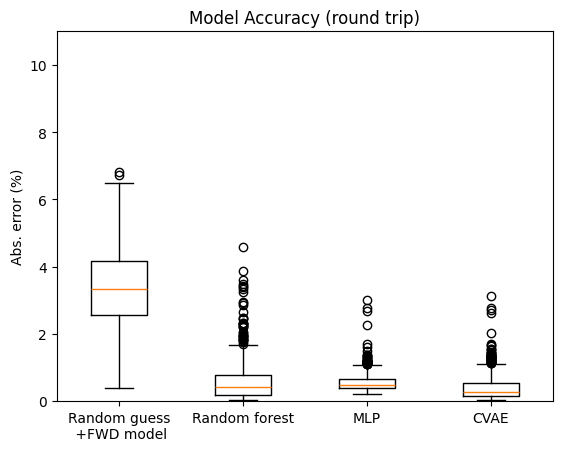

In [27]:
error_dist=[100*error_rand,
            100*mae_error_round,
            100*error_round_model_mlp,
            100*cvae_error]
labels=['Random guess\n +FWD model','Random forest','MLP','CVAE']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,11)
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (round trip)')

0       0.024884
1       0.045523
2       0.044942
3       0.034100
4       0.034725
          ...   
1194    0.034759
1195    0.034039
1196    0.051553
1197    0.019533
1198    0.024577
Length: 1199, dtype: float64


(0.0, 6.0)

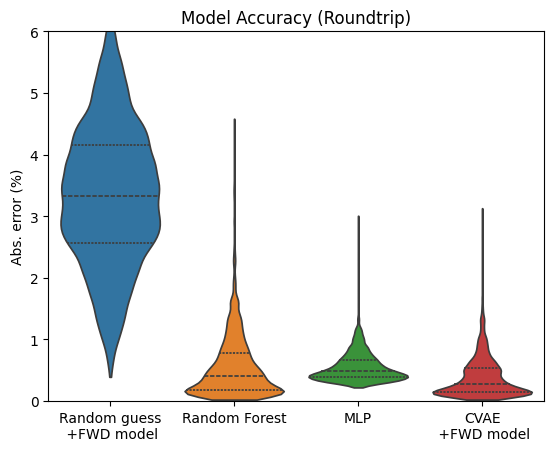

In [28]:
error_rand_reset=error_rand.reset_index(drop=True)
print(error_rand_reset)
df_plot=pd.DataFrame({'Random guess\n +FWD model':100*error_rand_reset,
                      'Random Forest':100*mae_error_round,
                      'MLP':100*error_round_model_mlp, 'CVAE\n +FWD model':100*cvae_error})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.6,split=False,orient='v')
plt.ylabel('Abs. error (%)')
plt.title('Model Accuracy (Roundtrip)')
plt.ylim(0,6)

0       0.024884
1       0.045523
2       0.044942
3       0.034100
4       0.034725
          ...   
1194    0.034759
1195    0.034039
1196    0.051553
1197    0.019533
1198    0.024577
Length: 1199, dtype: float64


(0.0, 6.0)

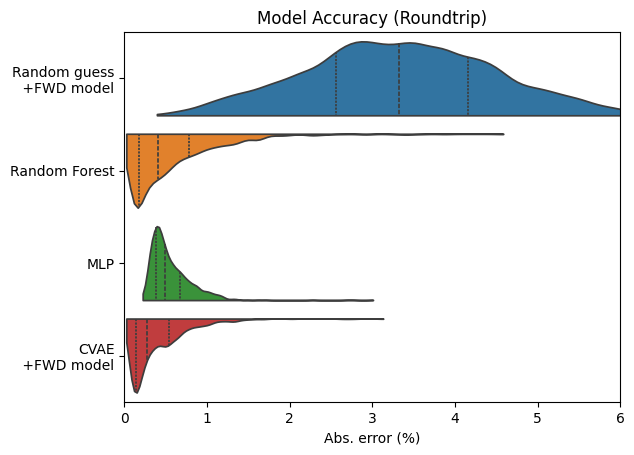

In [29]:
error_rand_reset=error_rand.reset_index(drop=True)
print(error_rand_reset)
df_plot=pd.DataFrame({'Random guess\n +FWD model':100*error_rand_reset,
                      'Random Forest':100*mae_error_round,
                      'MLP':100*error_round_model_mlp, 'CVAE\n +FWD model':100*cvae_error})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.6,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Roundtrip)')
plt.xlim(0,6)

## Different dataset size impact

In [30]:
def drop_shots(drop_factor,df_input,df_time):#,df_freq_int_clean):
    remove_n = int(drop_factor*len(df_input)) #number of shots to be dropped
    #print(remove_n)
    drop_indices = np.random.choice(df_input.index, remove_n, replace=False)
    df_input_subset = df_input.drop(drop_indices)
    df_time_subset = df_time.drop(drop_indices)
    print('The datasize is no: '+str(len(df_time_subset)))
    return df_input_subset,df_time_subset#,df_freq_int_subset

In [31]:
drop_factor=0.45
df_input_subset_1500,df_time_subset_1500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.60
df_input_subset_1k,df_time_subset_1k=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

drop_factor=0.81
df_input_subset_500,df_time_subset_500=drop_shots(drop_factor,df_input_reduced,df_pulse_200_reduced)

The datasize is no: 2198
The datasize is no: 1598
The datasize is no: 760


In [32]:
#split the dataset (X:dazzler param, Y:wizzler) 
X_train_1500, X_test_1500, y_train_1500, y_test_1500=models_tools.split_dataset_roundtrip(df_input_subset_1500,df_time_subset_1500,rand_split=False)
X_train_1k, X_test_1k, y_train_1k, y_test_1k=models_tools.split_dataset_roundtrip(df_input_subset_1k,df_time_subset_1k,rand_split=False)
X_train_500, X_test_500, y_train_500, y_test_500=models_tools.split_dataset_roundtrip(df_input_subset_500,df_time_subset_500,rand_split=False)

In [33]:
# Training the Random Forest forward models
forward_model_rf_1500=train_rf_forward(X_train_1500, X_test_1500, y_train_1500, y_test_1500)
forward_model_rf_1k=train_rf_forward(X_train_1k, X_test_1k, y_train_1k, y_test_1k)
forward_model_rf_500=train_rf_forward(X_train_500, X_test_500, y_train_500, y_test_500)

### RF

In [34]:
%%time
roundmodel_rf_1500=models_rf.ROUNDmodelRF(X_train_1500,X_test_1500,y_train_1500,y_test_1500)
roundmodel_rf_1500.train()
y_predict_round_1500=roundmodel_rf_1500.predict(y_test_1500)
mae_error_round_rf_1500=roundmodel_rf_1500.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 1min 45s, sys: 341 ms, total: 1min 45s
Wall time: 1min 45s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [35]:
%%time
roundmodel_rf_1k=models_rf.ROUNDmodelRF(X_train_1k,X_test_1k,y_train_1k,y_test_1k)
roundmodel_rf_1k.train()
y_predict_round_1k=roundmodel_rf_1k.predict(y_test_1k)
mae_error_round_rf_1k=roundmodel_rf_1k.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 1min 13s, sys: 279 ms, total: 1min 13s
Wall time: 1min 13s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [36]:
%%time
roundmodel_rf_500=models_rf.ROUNDmodelRF(X_train_500,X_test_500,y_train_500,y_test_500)
roundmodel_rf_500.train()
y_predict_round_500=roundmodel_rf_500.predict(y_test_500)
mae_error_round_rf_500=roundmodel_rf_500.error_calc()

Training the Random Forest forward model
Training the Random Forest backward model
Calculating the Mean Absolute Error
CPU times: user 29.2 s, sys: 153 ms, total: 29.3 s
Wall time: 29.3 s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### CVAE

In [37]:
#Create a CVAE model from a given dataset. Also train a FWD RF.
#Calculate the error in the predictions
def get_cvae_from_subset(t_200,df_input_subset,df_time_subset):
    X_train_subset, X_test_subset, y_train_subset, y_test_subset=models_tools.split_dataset_roundtrip(df_input_subset,df_time_subset,rand_split=False)
    
    #norm the X (Dazz parameters)
    #X_train_norm_subset=models_fcnn.norm_data(X_train_subset,X_train_subset)
    #X_test_norm_subset=models_fcnn.norm_data(X_test_subset,X_train_subset)

    #convert data to tensors (no need to normalize values for Y)
    #y_train_tensor_subset=torch.tensor(y_train_subset.values,dtype=torch.float32)
    #y_test_tensor_subset=torch.tensor(y_test_subset.values,dtype=torch.float32)

    #X_train_tensor_subset=torch.tensor(X_train_norm_subset.values,dtype=torch.float32)
    #X_test_tensor_subset=torch.tensor(X_test_norm_subset.values,dtype=torch.float32)

    #define the model
    total_in=len(t_200)+len(X_train_subset.columns) #number of input: pulse+Dazz
    out_dim=len(X_train_subset.columns)#dazz coefficients
    model_subset=models_vae.ConditionalVAE(
        in_pulse_features=len(t_200),
        num_param=out_dim,
        latent_dim=10,
        hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
        hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
    )

    model_cvae_subset,train_error_subset,test_error_subset=models_vae.train_vae(y_train_subset,y_test_subset,X_train_subset,X_test_subset,
                model_subset,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

    #train a RF forward model
    print('Training the RF FWD mode')
    forward_model_rf_subset=train_rf_forward(X_train_subset, X_test_subset, y_train_subset, y_test_subset)

    print('Calculating the error')
    cvae_error_subset=[]
    for i in range(len(y_test_subset)):
        #index_shot=random.randint(0,len(y_test))
        y_ex=y_test_subset.iloc[i]
        error_pred_cvae=get_error_cvae(y_ex,model_cvae_subset,forward_model_rf_subset,X_train_subset,device)
        cvae_error_subset.append(error_pred_cvae)
    cvae_error_subset=np.array(cvae_error_subset)
    return cvae_error_subset, model_cvae_subset

In [38]:
cvae_error_1500, model_cvae_1500=get_cvae_from_subset(t_200,df_input_subset_1500,df_time_subset_1500)

Training on: cpu
Finished epoch 0,latest loss 0.7585877180099487
Finished epoch 20,latest loss 0.05509350076317787
Finished epoch 40,latest loss 0.05175806209445
Finished epoch 60,latest loss 0.031278613954782486
Finished epoch 80,latest loss 0.017575740814208984
Finished epoch 100,latest loss 0.009500173851847649
Finished epoch 120,latest loss 0.017784779891371727
Finished epoch 140,latest loss 0.007904554717242718
Finished epoch 160,latest loss 0.007443363778293133
Finished epoch 180,latest loss 0.003988210111856461
Finished epoch 200,latest loss 0.0048516192473471165
Finished epoch 220,latest loss 0.0051711020059883595
Finished epoch 240,latest loss 0.006305962335318327
Finished epoch 260,latest loss 0.003054531989619136
Finished epoch 280,latest loss 0.014409887604415417
Finished epoch 299,latest loss 0.003327741986140609
Total time taken to train the model: 154.65s
Training the RF FWD mode
Calculating the error


In [39]:
cvae_error_1k, model_cvae_1k=get_cvae_from_subset(t_200,df_input_subset_1k,df_time_subset_1k)

Training on: cpu
Finished epoch 0,latest loss 0.8235644698143005
Finished epoch 20,latest loss 0.08429165929555893
Finished epoch 40,latest loss 0.05422194302082062
Finished epoch 60,latest loss 0.04738369211554527
Finished epoch 80,latest loss 0.021362995728850365
Finished epoch 100,latest loss 0.014238249510526657
Finished epoch 120,latest loss 0.008091315627098083
Finished epoch 140,latest loss 0.0069996328093111515
Finished epoch 160,latest loss 0.013588999398052692
Finished epoch 180,latest loss 0.008921444416046143
Finished epoch 200,latest loss 0.005091156344860792
Finished epoch 220,latest loss 0.013807618990540504
Finished epoch 240,latest loss 0.005774911027401686
Finished epoch 260,latest loss 0.003937846980988979
Finished epoch 280,latest loss 0.0027191012632101774
Finished epoch 299,latest loss 0.0046807038597762585
Total time taken to train the model: 44.39s
Training the RF FWD mode
Calculating the error


In [40]:
cvae_error_500, model_cvae_500=get_cvae_from_subset(t_200,df_input_subset_500,df_time_subset_500)

Training on: cpu
Finished epoch 0,latest loss 1.0196036100387573
Finished epoch 20,latest loss 0.14058160781860352
Finished epoch 40,latest loss 0.09185308963060379
Finished epoch 60,latest loss 0.08597653359174728
Finished epoch 80,latest loss 0.024500513449311256
Finished epoch 100,latest loss 0.01792442798614502
Finished epoch 120,latest loss 0.016095448285341263
Finished epoch 140,latest loss 0.011383481323719025
Finished epoch 160,latest loss 0.01512844767421484
Finished epoch 180,latest loss 0.006565592251718044
Finished epoch 200,latest loss 0.03143808990716934
Finished epoch 220,latest loss 0.004949542693793774
Finished epoch 240,latest loss 0.009564233012497425
Finished epoch 260,latest loss 0.009613500908017159
Finished epoch 280,latest loss 0.004696653224527836
Finished epoch 299,latest loss 0.027527639642357826
Total time taken to train the model: 32.61s
Training the RF FWD mode
Calculating the error


/tmp/ipykernel_7453/1641550966.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_dist,labels=labels)


Text(0.5, 1.0, 'CVAE error (mae)')

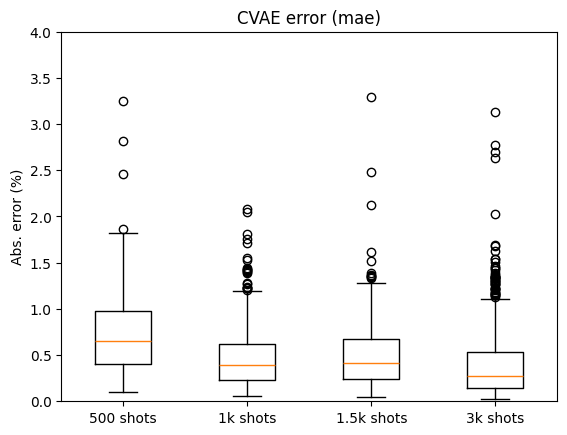

In [41]:
error_dist=[100*cvae_error_500,
            100*cvae_error_1k,
            100*cvae_error_1500,
            100*cvae_error]
labels=['500 shots','1k shots','1.5k shots','3k shots',]
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,4)
plt.ylabel('Abs. error (%)')
plt.title('CVAE error (mae)')

         Error Dataset Model
0     1.661864     500    RF
1     0.989291     500    RF
2     0.892963     500    RF
3     0.944988     500    RF
4     0.255955     500    RF
...        ...     ...   ...
1194  0.096732    3000  CVAE
1195  0.272629    3000  CVAE
1196  0.682551    3000  CVAE
1197  0.520536    3000  CVAE
1198  0.208747    3000  CVAE

[5134 rows x 3 columns]


(0.0, 3.0)

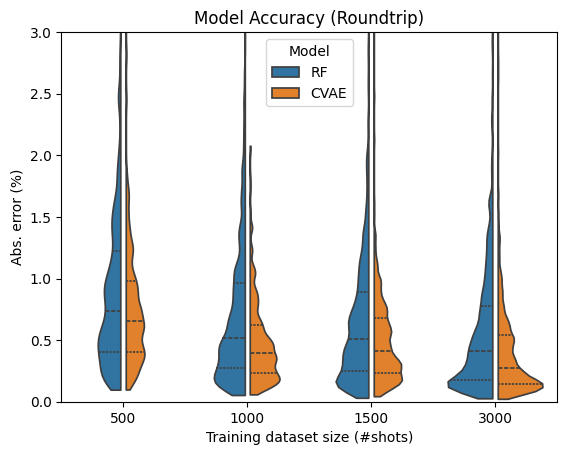

In [42]:
df_plot=pd.DataFrame({'Error':100*mae_error_round_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_500,'Dataset':'500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1k,'Dataset':'1000','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1500,'Dataset':'1500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error,'Dataset':'3000','Model':'CVAE'})))

print(df_plot)

sns.violinplot(data=df_plot,x='Dataset',y='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.4,split=True,orient='v')
plt.ylabel('Abs. error (%)')
plt.xlabel('Training dataset size (#shots)')
plt.title('Model Accuracy (Roundtrip)')
plt.ylim(0,3)

         Error Dataset Model
0     1.661864     500    RF
1     0.989291     500    RF
2     0.892963     500    RF
3     0.944988     500    RF
4     0.255955     500    RF
...        ...     ...   ...
1194  0.096732    3000  CVAE
1195  0.272629    3000  CVAE
1196  0.682551    3000  CVAE
1197  0.520536    3000  CVAE
1198  0.208747    3000  CVAE

[5134 rows x 3 columns]


(0.0, 3.0)

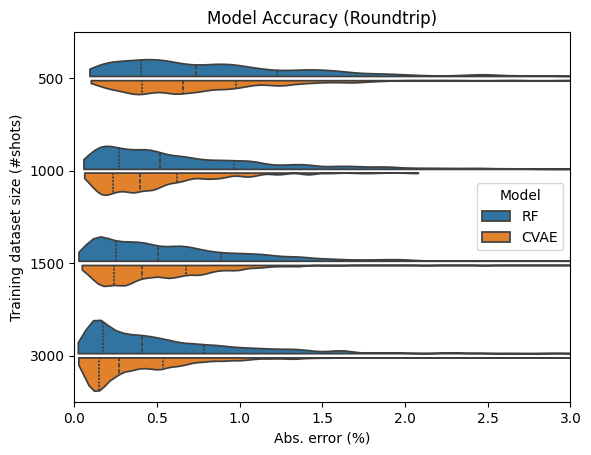

In [43]:
df_plot=pd.DataFrame({'Error':100*mae_error_round_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_500,'Dataset':'500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1k,'Dataset':'1000','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1500,'Dataset':'1500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error,'Dataset':'3000','Model':'CVAE'})))

print(df_plot)

sns.violinplot(data=df_plot,y='Dataset',x='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.4,split=True,orient='h')
plt.xlabel('Abs. error (%)')
plt.ylabel('Training dataset size (#shots)')
plt.title('Model Accuracy (Roundtrip)')
plt.xlim(0,3)

0       0.024884
1       0.045523
2       0.044942
3       0.034100
4       0.034725
          ...   
1194    0.034759
1195    0.034039
1196    0.051553
1197    0.019533
1198    0.024577
Length: 1199, dtype: float64
         Error Dataset Model
0     1.661864     500    RF
1     0.989291     500    RF
2     0.892963     500    RF
3     0.944988     500    RF
4     0.255955     500    RF
...        ...     ...   ...
1194  0.096732    3000  CVAE
1195  0.272629    3000  CVAE
1196  0.682551    3000  CVAE
1197  0.520536    3000  CVAE
1198  0.208747    3000  CVAE

[5134 rows x 3 columns]


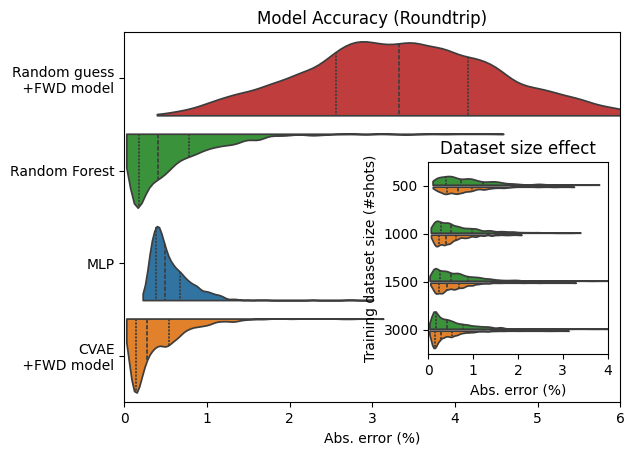

In [44]:
fig = plt.figure() #fig needed to add_axes later
error_rand_reset=error_rand.reset_index(drop=True)
print(error_rand_reset)
df_plot=pd.DataFrame({'Random guess\n +FWD model':100*error_rand_reset,
                      'Random Forest':100*mae_error_round,
                      'MLP':100*error_round_model_mlp, 'CVAE\n +FWD model':100*cvae_error})
#df_plot=pd.DataFrame({'RF':df_error_forward_rf})
#print(df_plot)
sns.violinplot(data=df_plot,inner='quart',cut=0,bw_adjust=.6,split=True,orient='h',
               palette=['tab:red','tab:green','tab:blue','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.title('Model Accuracy (Roundtrip)')
plt.xlim(0,6)

#inset plot (the datasize effect)
df_plot=pd.DataFrame({'Error':100*mae_error_round_rf_500,'Dataset':'500','Model':'RF'})
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1k,'Dataset':'1000','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round_rf_1500,'Dataset':'1500','Model':'RF'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*mae_error_round,'Dataset':'3000','Model':'RF'})))

df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_500,'Dataset':'500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1k,'Dataset':'1000','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error_1500,'Dataset':'1500','Model':'CVAE'})))
df_plot=pd.concat((df_plot,pd.DataFrame({'Error':100*cvae_error,'Dataset':'3000','Model':'CVAE'})))

print(df_plot)
ax = fig.add_axes([0.60, 0.21, 0.28, 0.40], facecolor='white') #[left, bottom, width, height]

sns.violinplot(data=df_plot,y='Dataset',x='Error',hue='Model',inner='quart',
               gap=0.1,cut=0,bw_adjust=.4,split=True,orient='h',
               palette=['tab:green','tab:orange'])
plt.xlabel('Abs. error (%)')
plt.ylabel('Training dataset size (#shots)')
plt.title('Dataset size effect')
plt.xlim(0,4)
ax.get_legend().remove()

## Custom shots

In [45]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_cust_cvae(y_ex,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,device):
    y_ex_tensor=torch.tensor(y_ex,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Custom shot',linestyle='--',linewidth=3)
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3)
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3)
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3)
    plt.xlabel('t(fs)',size=15)
    plt.ylabel('Intensity',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=2)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=2)
    plt.plot(x_o2_rf,y_o2_rf,linestyle='--',label='RF prediction',linewidth=2)
    plt.plot(x_o2_nn,y_o2_nn,linestyle='--',label='MLP prediction',linewidth=2)
    plt.xlabel(r'$\beta_2$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 2)
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_3|P^*)$',linewidth=2)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_3)$',alpha=0.5,linewidth=2)
    plt.plot(x_o3_rf,y_o3_rf,linestyle='--',label='RF prediction',linewidth=2)
    plt.plot(x_o3_nn,y_o3_nn,linestyle='--',label='MLP prediction',linewidth=2)
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 3)
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred. $P(\beta_4|P^*)$',linewidth=2)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=2)
    plt.plot(x_o4_rf,y_o4_rf,linestyle='--',label='RF prediction',linewidth=2)
    plt.plot(x_o4_nn,y_o4_nn,linestyle='--',label='MLP prediction',linewidth=2)
    plt.xlabel(r'$\beta_4$',size=15)
    plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

In [46]:
#define the curve to fit
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


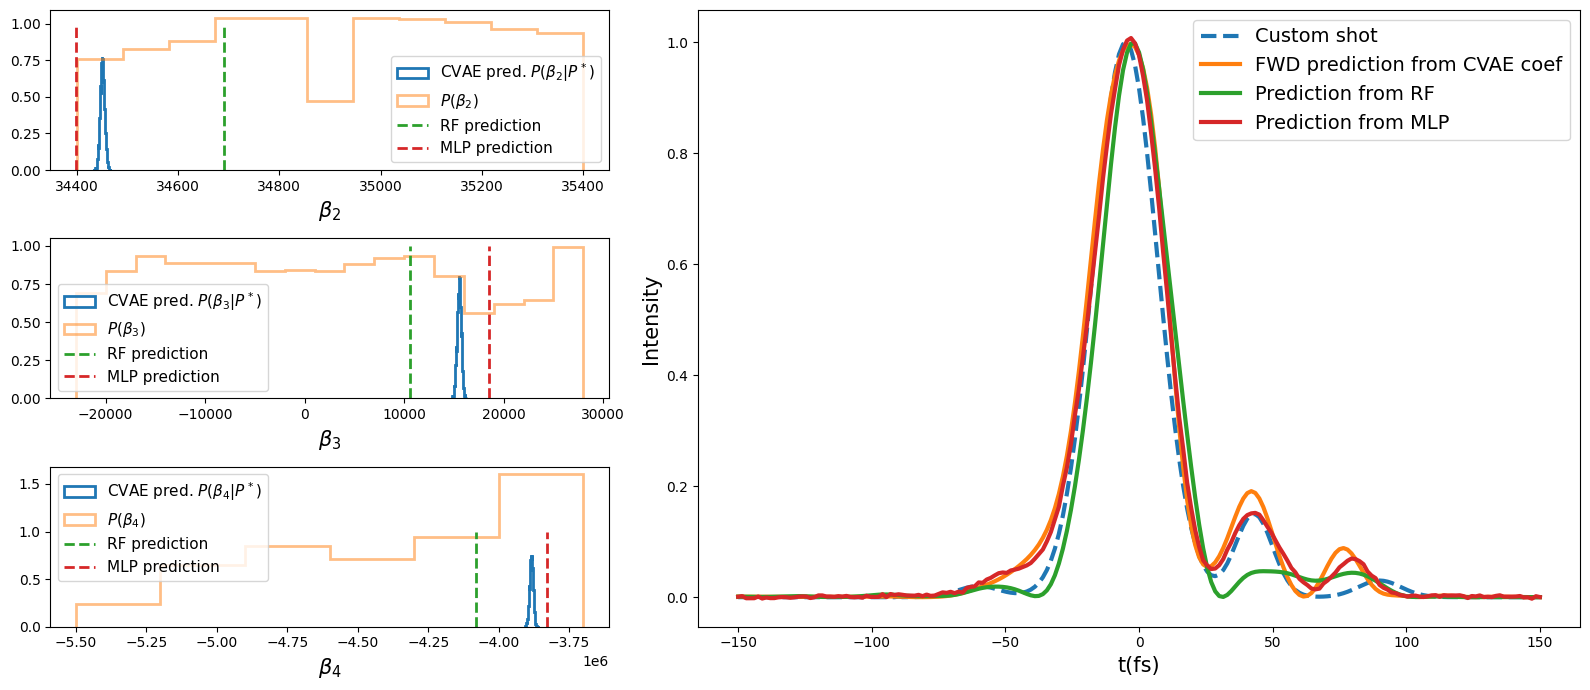

In [47]:
#y_cust_shot=func(t_200,1,-5,12,
#       0.03,+90,8,
#      0.15,+43,8,
#      0.04,-60,8,
#    0.01,0,0.1)

y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.02,-60,8,
                 1,-5,12,
                 0.15,+43,7,
                 0.03,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


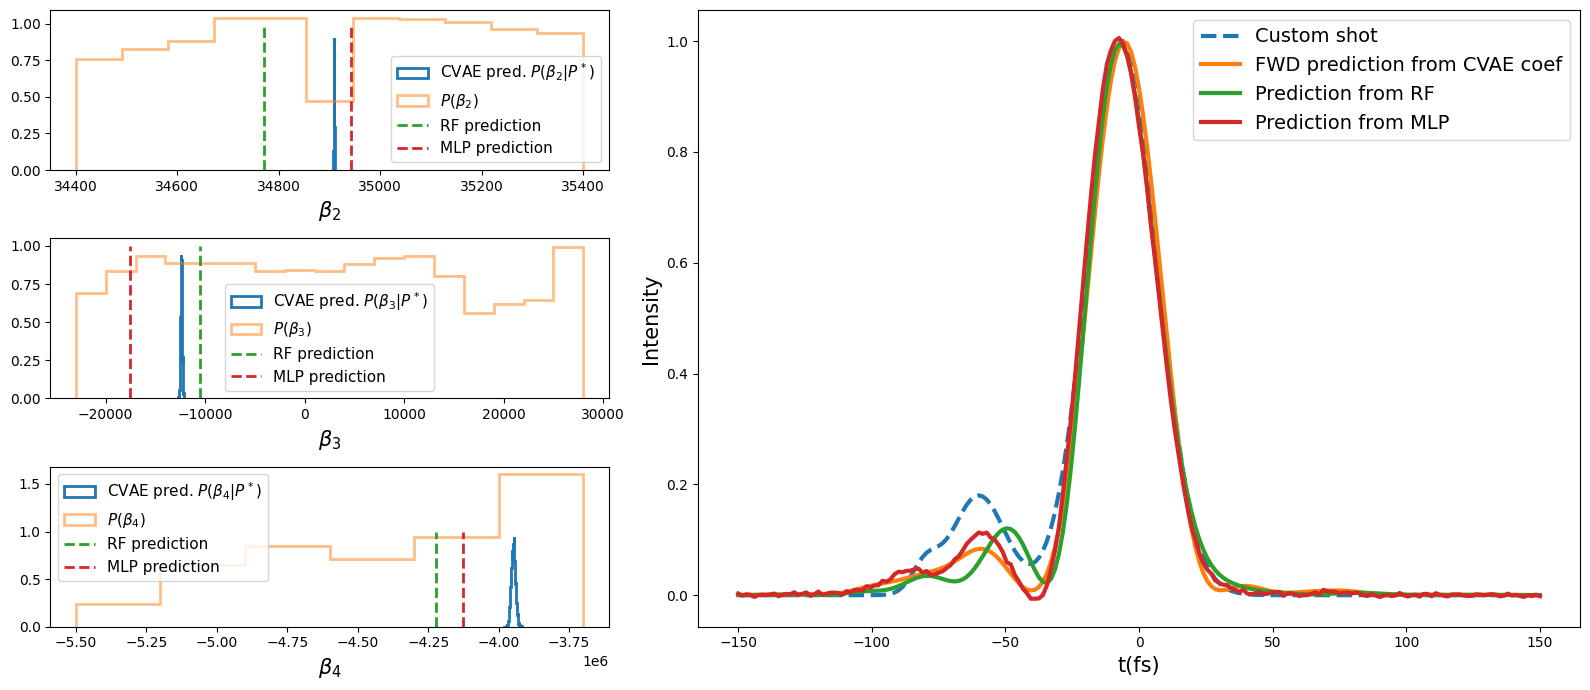

In [48]:
y_cust_shot=func(t_200,1,-6,13,
       0.05,-80,5,
      0.18,-60,10,
      0.,60,8,
    0.01,0,0.1)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
               roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)